In [206]:
import numpy as np
import pandas as pd
import datetime


df_heat = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/external/cs_cart_heats.csv', sep = ',', converters={'product_id':str,'ym_client_id':str})
# df_heat['ym_client_id'] = df_heat['ym_client_id'].astype(str)
cart = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/external/cs_cart_carts.csv',sep = ',',converters={'product_id':str})
users = pd.read_json('/Users/kuznetsovnikita/recommendations/data/external/сs_cart_users.json')
vygruz = pd.read_csv('/Users/kuznetsovnikita/PycharmProjects/pythonProject1/downloaded_file1.csv', sep=',',converters={'id':str})


In [188]:
# процент активных пользователей
act_users = users.loc[users.check_week == 'Заходил в течении недели'].shape[0]/users.shape[0]

In [198]:
cart['product_id'] = cart['product_id'].replace('',np.nan,regex= False).astype(float)
vygruz.cumdate = pd.to_datetime(vygruz.cumdate, infer_datetime_format=True)
vygruz.loc[:,['days_in_stock']] = (pd.to_datetime('2021-10-10')-vygruz.cumdate).dt.days
vygruz.loc[:,['discount']] =np.where(vygruz['Цена со скидкой'].isna(), 0,(vygruz['Цена шоурум']-vygruz['Цена со скидкой'])/vygruz['Цена шоурум'])
vygruz = vygruz.loc[vygruz.id != '']
vygruz.id = vygruz.id.replace(' ','',regex=True)

# vygruz.loc[~vygruz['Цена со скидкой'].isna()].loc[:,['Цена со скидкой','Цена шоурум','discount']]

In [199]:
## потоварная статистика
products = df_heat.loc[(df_heat.product_id != '0')&(df_heat.product_id != '16777215')] #выкидываю технические неполадки
# products = products.loc[(products['product_id'].apply(type) == int)] 
rating = products.groupby(['product_id'])['_id'].count().reset_index().sort_values('_id', ascending=False)

rating

,product_id,_id
1476,2000000077789,193
2873,2000000107837,189
997,2000000062983,164
2156,2000000097312,145
1345,2000000073651,127
...,...,...
1753,2000000086460,1
1752,2000000086392,1
1745,2000000086316,1
590,2000000044729,1


<AxesSubplot:ylabel='_id'>

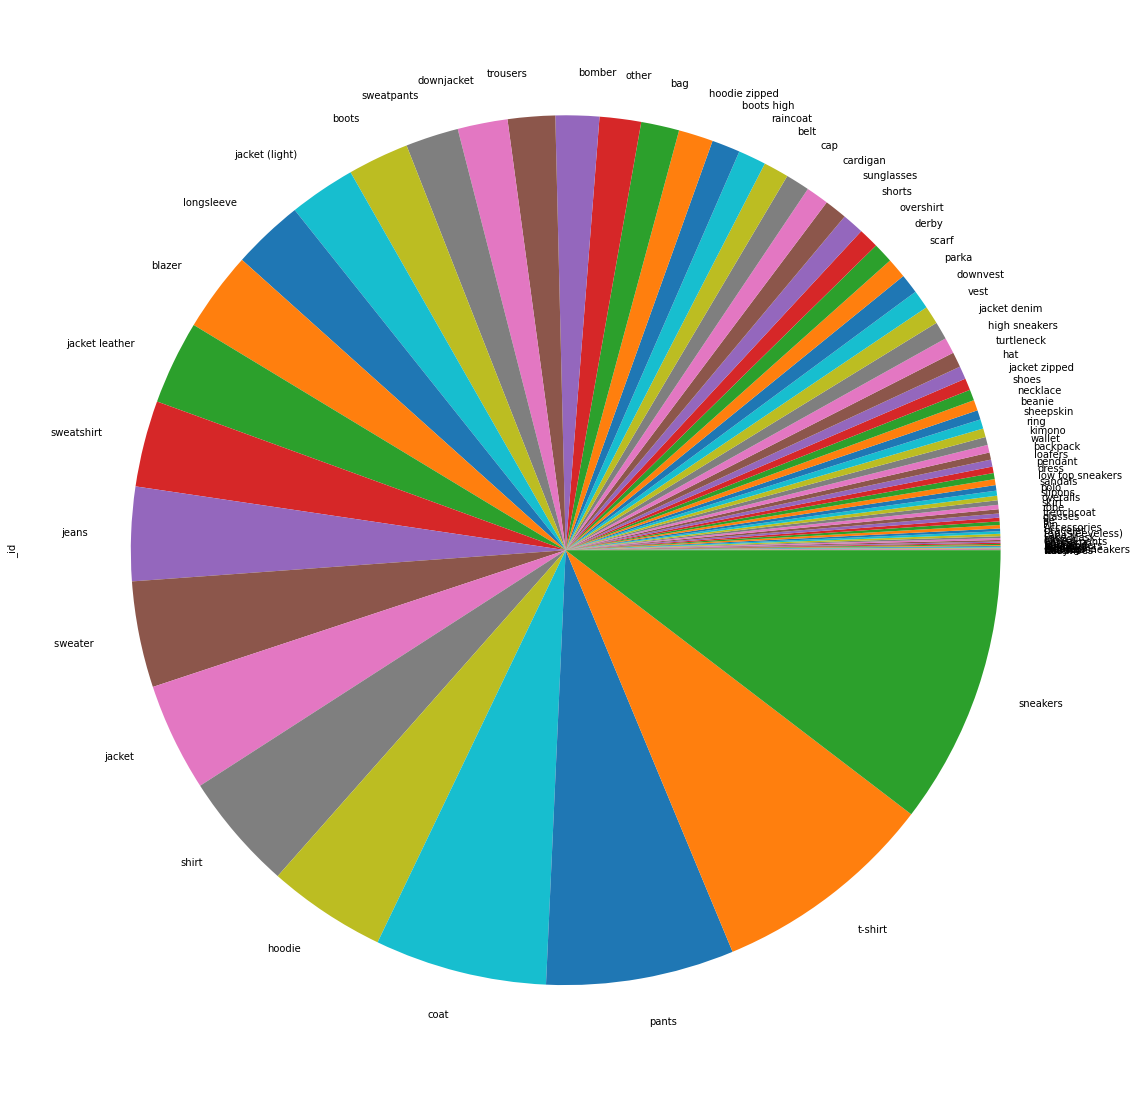

In [200]:
# добавляю всю информацию по каждой вещи
rating_full = rating.merge(vygruz, how = 'left', left_on='product_id', right_on='id')
# график с просмотрам по каждой категории товаров
rating_full.loc[:,['_id','categ']].groupby('categ')['_id'].sum().sort_values().plot(kind = 'pie', figsize = (20,20))

In [60]:
rating.merge(vygruz, how='left', left_on='product_id', 
             right_on='id').loc[:,['id','_id','days_in_stock','Цена шоурум','discount','categ','cond']].to_csv('rating_for_lm.csv')

array([[<AxesSubplot:ylabel='C'>],
       [<AxesSubplot:ylabel='W'>]], dtype=object)

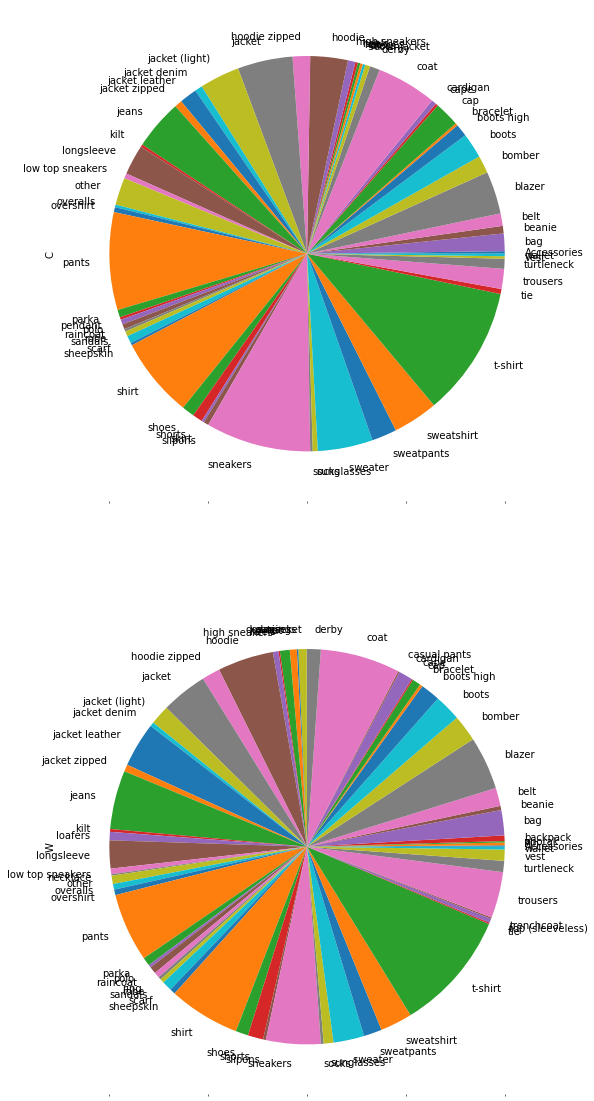

In [209]:
# теперь аналогично посмотрим на добавления в корзину/вишлисты
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False)
# cart['product_id'] = cart.product_id

cart_full = cart.merge(vygruz.loc[:,['id','categ']], how='left', left_on='product_id', right_on='id')

cart_full_gb = cart_full.groupby(['type','categ'])['id'].count().reset_index()
cart_full_piv = cart_full_gb.sort_values(['type','id'], 
                                         ascending=[True, False]).pivot(columns = ['type'], 
                                                                        index = 'categ',
                                                                        values = 'id')


cart_full_piv.plot(kind = 'pie',subplots = True, layout = (2,1), figsize = (20,20), legend = False)


In [231]:
# достаю списки товаров из корзин/вишлистов/заказов каждого клиента
cart_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'W')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
wish_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'C')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
# засовываю в единый фрейм с учетом непересечений
cart_wish_user_prod = cart_user_prod.join(wish_user_prod, 
                                          how = 'outer', 
                                          on ='ym_client_id', 
                                          lsuffix = '_cart', 
                                          rsuffix = '_wish').drop_duplicates('ym_client_id').reset_index().drop(columns = 'index')
cart_wish_user_prod
# wish_user_prod

,ym_client_id,product_id_cart,product_id_wish
0,1586517765142996502,"[2000000079578, 2000000071244]",[2000000109862]
1,1592847484780941724,[2000000040967],NaN
2,15945421401032860445,[2000000103075],NaN
3,1594795295110685242,"[2000000071398, 2000000087337]",NaN
4,15958550101040682370,[2000000077543],"[2000000077482, 2000000039305, 2000000076768, ..."
...,...,...,...
255,1636377082440912601,NaN,[2000000087443]
256,16363791901031187733,NaN,[2000000093017]
257,1636379563472394627,NaN,[2000000081755]
258,1636386730492846125,NaN,[2000000093345]


In [294]:
# создаю матрицу предпочтений по трем видам (пока что) оценок: просмотр товара, добавление в корзину/вишлист, добавление в заказ
products['ym_client_id'] = products['ym_client_id'].astype(str)
products = products.loc[products.product_id != 'NaN']

# делаю список со всеми возможными вещами, обрезать по наличию буду потом
all_items = np.concatenate([products.product_id.unique(),cart.product_id.unique()])
product_id_cols = [str(i) for i in all_items]
product_id_cols.extend(['product_id_wish','product_id_cart','product_id', 'ym_client_id'])
product_id_cols.reverse()

user_product_heat = products.groupby('ym_client_id')['product_id'].apply(list).reset_index()
user_product_heat = user_product_heat.merge(cart_wish_user_prod, how ='outer', on = 'ym_client_id')
user_product_heat = user_product_heat.reindex(columns=product_id_cols, fill_value=0).set_index('ym_client_id')
user_product_heat = user_product_heat.loc[:,~user_product_heat.columns.duplicated()]
user_product_heat.fillna({'product_id':'', 'product_id_cart':'', 'product_id_wish':''}, inplace=True)

# заполняю матрицу предпочтений ранжированными значениями (!!запихнуть в функцию потом!!)
for i in range(user_product_heat.shape[0]):
    if type(user_product_heat.loc[:,'product_id'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id'].iat[i]:
            user_product_heat[product].iat[i] += 1
    if type(user_product_heat.loc[:,'product_id_cart'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id_cart'].iat[i]:
            user_product_heat[product].iat[i] += 10
    if type(user_product_heat.loc[:,'product_id_wish'].iat[i])== list:
        for product in user_product_heat.loc[:,'product_id_wish'].iat[i]:
            user_product_heat[product].iat[i] += 5

user_product_heat.drop(columns = ['product_id','product_id_cart','product_id_wish'], inplace = True)

#после этого, по сути, надо дропнуть вещи, которые уже архивные

user_product_heat

,2000000090177,2000000018416,2000000046327,2000000109800,2000000018447,2000000054926,2000000057118,2000000049717,2000000102214,2000000078571,...,2000000060514,2000000075310,2000000082929,2000000075181,2000000063423,2000000084473,2000000093321,2000000094601,2000000099705,2000000076294
ym_client_id,,,,,,,,,,,,,,,,,,,,,
1586517765142996502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586839436824718143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586877094630823534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587480513689496288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587732076104489525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636113933411585775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636150433962596616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636163068984203323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
user_product_heat.loc[user_product_heat['2000000090177'] != 0]

,2000000090177,2000000018416,2000000046327,2000000109800,2000000018447,2000000054926,2000000057118,2000000049717,2000000102214,2000000078571,...,2000000060514,2000000075310,2000000082929,2000000075181,2000000063423,2000000084473,2000000093321,2000000094601,2000000099705,2000000076294
ym_client_id,,,,,,,,,,,,,,,,,,,,,
16144338261041961136,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628186816528665055,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1635923435269480339,10,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [292]:
user_product_heat.iloc[100,3:].unique()

array([0, 2, 1, 5], dtype=object)